<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЗАДАНИЕ 10. ПОДСТАНОВОЧНЫЙ АЛГОРИТМ.**

Оценим параметры функций правдоподобия $\mu^y$ и $
\Sigma^y$ по частям обучающей выборки $X^l_y$ для каждого класса $y \in Y$. Затем эти выборочные оценки подставим в оптимальный байесовский классификатор. Получим байесовский нормальный классификатор, который называется также подстановочным.

$\hat{\mu}(x) = \frac{1}{m}\sum\limits_{i = 1}^m x_i$

$\hat{\Sigma} = \frac{1}{m - 1} \sum \limits_{i=1}^m (x - \hat{\mu}_{y_i})^T (x - \hat{\mu}_{y_i})$

$\hat{P}_y = \frac{|X_y^l|}{|X^l|}$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

"""
Классифиатор, обучаемый подстановочным алгоритмом
"""
class BayesPlugIn:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.train()

    """
    Метод рассчитывает плотность по объекты, мат ожиданию и матрице ковариации
    """
    @staticmethod
    def gauss(x, mu, cov):
        xx = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        n = len(x)
        return 1 / (np.sqrt((2 * np.pi)**n) * det) * np.exp(-0.5 * np.transpose(xx) * inv * xx)

    """
    Метод считает для каждого мат ожидание, матрицу ковариации и приорную вероятность
    """
    def train(self):
        self.m, self.k = X.shape
        
        self.classes = pd.unique(self.y)
        self.mu = {}
        self.cov = {c: np.zeros((self.k, self.k)) for c in self.classes}
        self.prior = {}
        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()
            
            for cur in self.X.iloc[self.y[self.y == c].index].values:
                self.cov[c] += np.array([(cur - self.mu[c])]) * np.transpose(np.array([cur - self.mu[c]]))
            self.cov[c] /= self.m - 1

            self.prior[c] = len(self.X.iloc[self.y[self.y == c].index]) / self.m

    """
    Метод рассчитывет вероятности принадлежности объекта каждому классу
    и возвращает наиболее вероятный
    """
    def predict(self, obj):
        posteriors = []
        classes = []

        for c in self.classes:
            prior = np.log(self.prior[c])
            mu = self.mu[c]
            cov = self.cov[c]
            posterior = prior + np.sum(np.log(self.gauss(obj, mu, cov)))
            posteriors.append(posterior)
            classes.append(c)
        
        return classes[np.argmax(posteriors)]

    """
    Метод рисует карту классификации [0,1] x [0,1]
    """
    def draw_classification_map(self):
        i, j = 'x', 'y'
        color = {0: 'blue', 1: 'red'}
        fig, ax = plt.subplots()

        for xi in np.arange(0, 1, 0.03):
            for yi in np.arange(0, 1, 0.03):
                cat = self.predict([xi, yi])
                plt.scatter(xi, yi, color='none', edgecolor=color[cat])

        for ind in range(self.m):
            xi = self.X[i].values[ind]
            yi = self.X[j].values[ind]
            cat = self.y.values[ind]
            clr = color[cat]
            plt.scatter(xi, yi, color=clr)

        plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

1) Сгенерируем обучающую выборку и разделим параболой $y = -\frac{(3x - 1.5)^2}{2} + 0.7$:

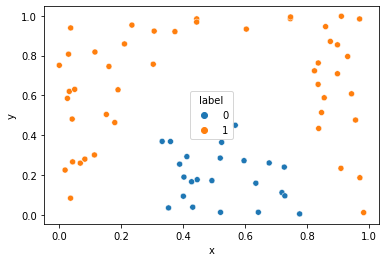

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd


x_i = []
y_i = []

def f(x):
    return -(3*x - 1.5)**2 / 2 + 0.7

for cur in np.random.sample((100, 2)):
    if abs(f(cur[0]) - cur[1]) < 0.2:
        continue
    x_i.append(cur)
    if f(cur[0]) > cur[1]:
        y_i.append(0)
    else:
        y_i.append(1)

df = pd.DataFrame({
  'x': [cur[0] for cur in x_i],
  'y': [cur[1] for cur in x_i],
  'label': [cur for cur in y_i]
})

X, y = df[['x', 'y']], df.label

sns.scatterplot(data=df, x='x', y='y', hue='label')

Результат классификации:

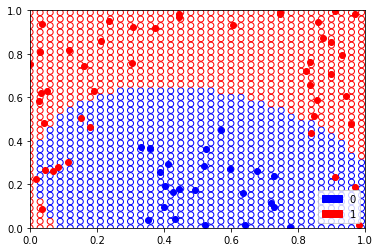

In [ ]:
BP = BayesPlugIn(X, y)
BP.draw_classification_map()

2) Сгенерируем обучающую выборку и разделим эллипсом $(x-0.5)^2 + (y-0.5)^2 <= 0.2^2$:

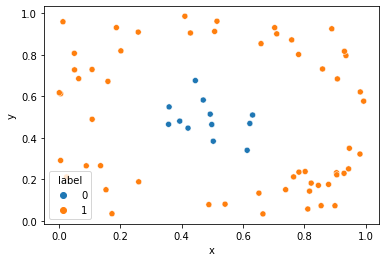

In [ ]:
x_i = []
y_i = []

def f(x, y):
    return (x - 0.5)**2 + (y - 0.5)**2 - 0.2**2

for cur in np.random.sample((100, 2)):
    if abs(f(cur[0], cur[1])) < 0.1 and f(cur[0], cur[1]) > 0:
        continue
    x_i.append(cur)
    if f(cur[0], cur[1]) < 0:
        y_i.append(0)
    else:
        y_i.append(1)

df = pd.DataFrame({
  'x': [cur[0] for cur in x_i],
  'y': [cur[1] for cur in x_i],
  'label': [cur for cur in y_i]
})

X, y = df[['x', 'y']], df.label

sns.scatterplot(data=df, x='x', y='y', hue='label')

Карта классификации:

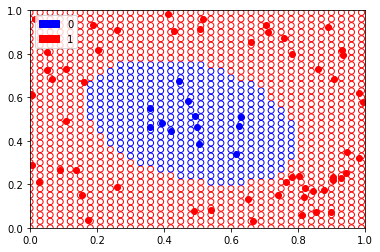

In [ ]:
BP = BayesPlugIn(X, y)
BP.draw_classification_map()


3) Сгенерируем обучающую выборку и разделим гиперболой $\frac{(x-0.5)^2}{0.4^2} - \frac{(y-0.5)^2}{0.4^2} = 0.2^2$:

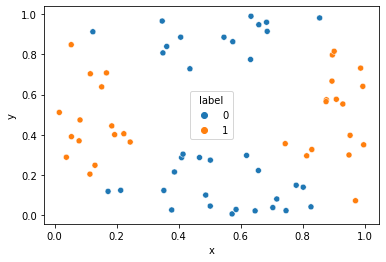

In [ ]:
|import numpy as np
import seaborn as sns
import pandas as pd


x_i = []
y_i = []

def f(x, y):
    return (x - 0.5)**2 / 0.4**2 - (y - 0.5)**2 / 0.4**2 - 0.2**2

for cur in np.random.sample((100, 2)):
    if abs(f(cur[0], cur[1])) < 0.2:
        continue
    x_i.append(cur)
    if f(cur[0], cur[1]) < 0:
        y_i.append(0)
    else:
        y_i.append(1)

df = pd.DataFrame({
  'x': [cur[0] for cur in x_i],
  'y': [cur[1] for cur in x_i],
  'label': [cur for cur in y_i]
})

X, y = df[['x', 'y']], df.label

sns.scatterplot(data=df, x='x', y='y', hue='label')

Карта классификации:

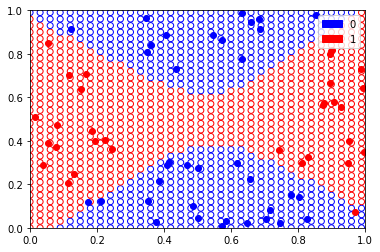

In [ ]:
BP = BayesPlugIn(X, y)
BP.draw_classification_map()


Преимущество модели:

- результаты сильно качественне наивного байессового алгоритма, так каку нет предположения о независимости компонент

Недостатки модели:

- плохие результаты, если распределение далеко от нормального
- если длина выборки меньше размерности пространства, то $\Sigma$ вырожденная и метод неприменим